In [60]:
import numba
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import tensorflow as tf
import tensorflow_probability as tfp

In [61]:
from scipy.sparse import random
from scipy import stats
from numpy.random import default_rng
rng = default_rng()
rvs = stats.uniform().rvs
# rvs = stats.poisson(5, loc=10).rvs
X = random(20, 100, density=0.25, random_state=rng, data_rvs=rvs)
X.A

array([[0.        , 0.        , 0.        , ..., 0.        , 0.8225588 ,
        0.        ],
       [0.        , 0.57807315, 0.        , ..., 0.30311056, 0.        ,
        0.        ],
       [0.        , 0.95101113, 0.        , ..., 0.29526663, 0.62904245,
        0.        ],
       ...,
       [0.        , 0.        , 0.96918751, ..., 0.        , 0.        ,
        0.79637558],
       [0.        , 0.        , 0.64229011, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.56522952, 0.        ,
        0.        ]])

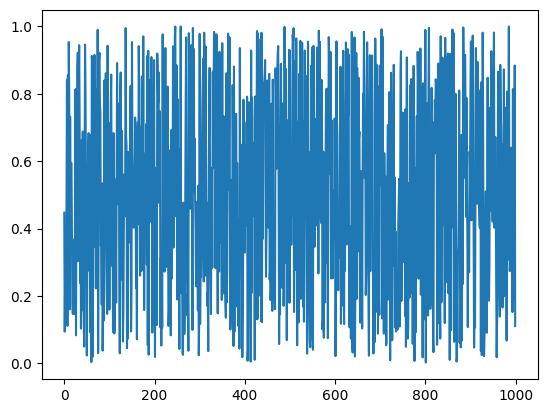

In [62]:
n = 20
p = 50
s = np.random.default_rng().uniform(0,1, n*p)
X = np.reshape(s,(-1, p))
X.shape
df = pd.DataFrame(X)
#  we let r=25

y = np.zeros(n) #initialising y array
for i in range(n):
    yTemp = df.iloc[i,0:25].sum() + np.random.normal(0, 1) #generating y values from a simple linear model with gaussian noise
    y[i] = yTemp

plt.plot(s)

In [63]:
param = dict(sigma1=1, sigma2=1, sigmay=1, p=100)

In [64]:
def multGaussian(X, mu,sigma):
    m = len(mu)
    sigma2 = np.diag(sigma)
    X = X-mu.T
    p = 1/((2*np.pi)**(m/2)*np.linalg.det(sigma2)**(0.5)) * np.exp(-0.5*np.sum(X.dot(np.linalg.pinv(sigma2))*X,axis=1))
    return p

In [65]:
def diracDelta(x, eps):
    return 1.0/(eps*np.sqrt(2.*np.pi)) * np.exp(-x**2 / (2.*eps**2))
diracDelta = np.vectorize(diracDelta)

In [66]:
sigma1 = 1
sigma2 = 0.1
sigmay = 1
niter = 100
gamma = 0.1
rho = 1

In [68]:
p = len(X[1])
n = len(X)
b = p + n
theta = np.array([np.zeros(p)]).T
AtA, Atz, z = [], [], []
for t in range(niter):
    print("Start of %sth iteration" % str(t))
    for i in range(b):
        if i <= p-1:
            e = np.array([np.zeros(p)])
            e[0][i] = 1
            A = e * 1/sigma2
            AtA.append(np.matmul(A.T, A))
            sigsig = sigma2 / sigma1
            w1 = gamma * sigsig / ((gamma * sigsig) + ((1-gamma) * np.exp(-(1-sigsig**2) * np.linalg.norm(np.matmul(A[0], theta))/2)))
            w2 = 1 - w1
            U = np.random.uniform()
            if U > w1:
                mu = (1 - sigsig**2) * np.matmul(A[0], theta)
                sigmaz = 1 - sigsig**2
                z.append(np.random.normal(mu, sigmaz))
            else:
                z.append(0)
            # print(A)
            Atz.append(A.T * z[i])
            
        else:
            X_t = X[i-p].reshape(1, p)
            A = X_t / sigmay
            AtA.append(np.matmul(A.T, A))
            z.append(y[i-p] / sigmay)
            Atz.append(A.T * z[i])
            # print((A.T * z[i]).shape)
    # print(sum(AtA))
    print("End of sampling z values")
    sumAAtinv = np.linalg.inv(sum(AtA))
    mu_theta = np.matmul(sumAAtinv, sum(Atz))
    # print(mu_theta.shape)
    sigma_theta = np.linalg.inv(sum(AtA)) * rho**2
    L = np.linalg.cholesky(sigma_theta)
    # print(L)
    print("Start of sampling theta")
    theta_new = mu_theta + np.matmul(L, np.reshape(np.random.multivariate_normal(np.zeros(p), np.identity(p)), (-1, 1)))
    theta = theta_new
    print(theta.shape)
    # break
    AtA, Atz, z = [], [], []
    print("-------------------------------------------------------")
    

Start of 0th iteration
End of sampling z values
Start of sampling theta
(50, 1)
-------------------------------------------------------
Start of 1th iteration
End of sampling z values
Start of sampling theta
(50, 1)
-------------------------------------------------------
Start of 2th iteration
End of sampling z values
Start of sampling theta
(50, 1)
-------------------------------------------------------
Start of 3th iteration
End of sampling z values
Start of sampling theta
(50, 1)
-------------------------------------------------------
Start of 4th iteration
End of sampling z values
Start of sampling theta
(50, 1)
-------------------------------------------------------
Start of 5th iteration
End of sampling z values
Start of sampling theta
(50, 1)
-------------------------------------------------------
Start of 6th iteration
End of sampling z values
Start of sampling theta
(50, 1)
-------------------------------------------------------
Start of 7th iteration
End of sampling z values


In [74]:
np.zeros(niter)
theta.T[0]

array([0.23525191, 1.00592085, 0.85758891, 0.11187783, 0.86993014,
       0.21967219, 0.27639417, 0.62381326, 0.28281903, 0.81791128,
       0.63140105, 0.12409753, 0.41319067, 0.0244685 , 0.2828104 ,
       0.23271173, 0.39181471, 0.28637669, 0.23415048, 0.77837049,
       1.36429477, 0.82593136, 0.65254795, 0.16149481, 0.22282314,
       0.75158643, 0.6730694 , 0.45053439, 0.20360862, 0.60861223,
       0.26468026, 0.48860267, 0.62544187, 0.12650477, 0.47409994,
       0.35057116, 0.2711268 , 0.44393908, 0.83893995, 0.20771757,
       0.72945065, 0.24550468, 0.27737027, 0.67011711, 0.59547288,
       0.19636916, 0.2613518 , 0.82595441, 0.20140449, 0.469924  ])

In [77]:
def splitGibbs(sigma1, sigma2, sigmay, p, n, niter=1000):
    gamma = 0.1
    rho = 1
    b = p + n
    theta = np.array([np.zeros(p)]).T
    AtA, Atz, z = [], [], []
    samples = []
    # samples = np.zeros(niter)
    for t in range(niter):
        print("Start of %sth iteration" % str(t))
        for i in range(b):
            if i <= p-1:
                e = np.array([np.zeros(p)])
                e[0][i] = 1
                A = e * 1/sigma2
                AtA.append(np.matmul(A.T, A))
                sigsig = sigma2 / sigma1
                w1 = gamma * sigsig / ((gamma * sigsig) + ((1-gamma) * np.exp(-(1-sigsig**2) * np.linalg.norm(np.matmul(A[0], theta))/2)))
                w2 = 1 - w1
                U = np.random.uniform()
                if U > w1:
                    mu = (1 - sigsig**2) * np.matmul(A[0], theta)
                    sigmaz = 1 - sigsig**2
                    z.append(np.random.normal(mu, sigmaz))
                else:
                    z.append(0)
                # print(A)
                Atz.append(A.T * z[i])
                
            else:
                X_t = X[i-p].reshape(1, p)
                A = X_t / sigmay
                AtA.append(np.matmul(A.T, A))
                z.append(y[i-p] / sigmay)
                Atz.append(A.T * z[i])
                # print((A.T * z[i]).shape)
        # print(sum(AtA))
        print("End of sampling z values")
        sumAAtinv = np.linalg.inv(sum(AtA))
        mu_theta = np.matmul(sumAAtinv, sum(Atz))
        # print(mu_theta.shape)
        sigma_theta = np.linalg.inv(sum(AtA)) * rho**2
        L = np.linalg.cholesky(sigma_theta)
        # print(L)
        print("Start of sampling theta")
        theta_new = mu_theta + np.matmul(L, np.reshape(np.random.multivariate_normal(np.zeros(p), np.identity(p)), (-1, 1)))
        theta = theta_new
        # print(theta.shape)
        # break
        AtA, Atz, z = [], [], []
        samples.append(theta.T[0])
        # samples[t]=theta.T[0]
        print("-------------------------------------------------------")
    
    return samples

In [78]:
trace = splitGibbs(sigma1 = 1, sigma2= 0.1, sigmay= 1, p = len(X[1]), n = len(X),  niter=10000)
len(trace)

Start of 0th iteration
End of sampling z values
Start of sampling theta
-------------------------------------------------------
Start of 1th iteration
End of sampling z values
Start of sampling theta
-------------------------------------------------------
Start of 2th iteration
End of sampling z values
Start of sampling theta
-------------------------------------------------------
Start of 3th iteration
End of sampling z values
Start of sampling theta
-------------------------------------------------------
Start of 4th iteration
End of sampling z values
Start of sampling theta
-------------------------------------------------------
Start of 5th iteration
End of sampling z values
Start of sampling theta
-------------------------------------------------------
Start of 6th iteration
End of sampling z values
Start of sampling theta
-------------------------------------------------------
Start of 7th iteration
End of sampling z values
Start of sampling theta
--------------------------------

10000

In [79]:
tf.convert_to_tensor(np.asarray(trace), dtype=tf.float32)

<tf.Tensor: shape=(10000, 50), dtype=float32, numpy=
array([[0.4481376 , 0.4048717 , 0.26482722, ..., 0.36787453, 0.46460676,
        0.23466927],
       [0.67174387, 0.56829053, 0.440713  , ..., 0.68081856, 0.07234657,
        0.02173242],
       [0.85809076, 0.13614687, 0.53734297, ..., 0.8668088 , 0.30445904,
        0.274006  ],
       ...,
       [1.1246753 , 0.2569906 , 0.61452824, ..., 0.9937455 , 0.14767523,
        0.759682  ],
       [0.03259237, 0.43712538, 0.77942884, ..., 0.19964941, 0.09247811,
        0.8331416 ],
       [0.30441406, 0.5532928 , 0.73582274, ..., 0.30030593, 0.14405559,
        0.97676   ]], dtype=float32)>

In [80]:
sample = tf.convert_to_tensor(np.asarray(trace), dtype=tf.float32)
ess = tfp.mcmc.effective_sample_size(sample, filter_beyond_positive_pairs=True)
print(ess.shape)
mean, variance = tf.nn.moments(sample, axes=0)
standard_error = tf.sqrt(variance / ess)

(50,)


In [85]:
mean

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([0.53140956, 0.47203115, 0.48137495, 0.50243735, 0.47448584,
       0.49996132, 0.45959634, 0.42029443, 0.41854155, 0.4430714 ,
       0.45798427, 0.4368665 , 0.4975326 , 0.42932138, 0.5026746 ,
       0.41196108, 0.46736386, 0.524939  , 0.41089684, 0.40919712,
       0.48603302, 0.50060415, 0.37335563, 0.4795845 , 0.50701106,
       0.4213757 , 0.3660387 , 0.5013995 , 0.4463931 , 0.42556855,
       0.4849133 , 0.4019998 , 0.444267  , 0.46069404, 0.45663092,
       0.4467751 , 0.40842912, 0.4388772 , 0.38408765, 0.4417381 ,
       0.4901628 , 0.4194423 , 0.51878977, 0.39764458, 0.41829628,
       0.39932367, 0.4419939 , 0.45716035, 0.45955947, 0.48766798],
      dtype=float32)>

In [86]:
standard_error

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([0.00385277, 0.00392657, 0.00398533, 0.00386524, 0.00408208,
       0.0040154 , 0.00394777, 0.00445147, 0.00429978, 0.0041568 ,
       0.00406899, 0.00434201, 0.00397013, 0.00425737, 0.00392446,
       0.00446983, 0.00397178, 0.00389305, 0.00440523, 0.00453375,
       0.00394787, 0.00400937, 0.00496516, 0.00396223, 0.00392868,
       0.00442562, 0.00495832, 0.00391366, 0.00420371, 0.00417408,
       0.00398947, 0.00442893, 0.00418321, 0.00402911, 0.00409266,
       0.00408704, 0.00452966, 0.00414719, 0.00468036, 0.00420174,
       0.00402513, 0.0044057 , 0.00394802, 0.00465954, 0.00436194,
       0.00456786, 0.00410416, 0.00407588, 0.0040925 , 0.0040313 ],
      dtype=float32)>

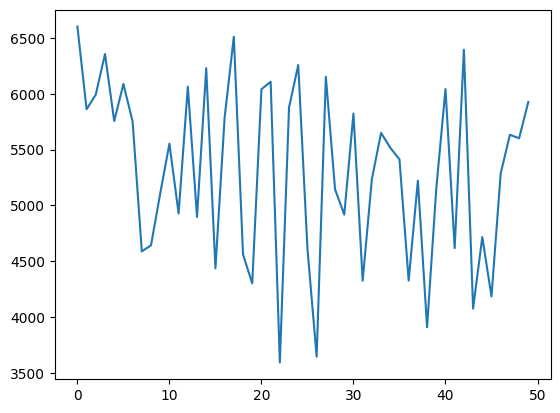

In [84]:
plt.plot(ess)

In [ ]:
pd.DataFrame(np.reshape(trace, (50, 10000)))

# multiESS(pd.DataFrame(np.reshape(trace, (10000, 50))), b="sqroot")